# Credit
While thinking through and researching this approach, I see that Suraj Parmar had already implemented this ([medium post](https://parmarsuraj99.medium.com/era-of-transformers-792e5960e287)). Most of the code here reflects his code there. There are some slight variations because the transformer implementation is taken from my reimplmentation of nano-gpt [here](https://github.com/vispz/andrej_lectures/blob/main/gpt/gpt.py).

# Goal

The goal of this notebook is to create a multi GPU implementation of numerai era transformers.

1. Loads the data offered by numerai. _The numerai dataset is split into eras corresponding to a specific week. Each era has features and targets for ~5k equities/stocks. Targets correspond to some form of ranked return._
2. Pads the dataset such that each era has a fixed number of equities.
3. Push the padded X, targets, mask into a pytorch dataloader.
4. Build the simplest possible model MSE(sigmoid(w@x))

In [20]:
from IPython.display import display
from typing import *

import gc
import lightgbm as lgb
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numerapi
import json
import numpy as np
import scipy.stats as stats
import time
import os
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm.notebook import tqdm
from dataclasses import dataclass

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        'legend.fontsize': 'x-large',
        'axes.labelsize': 'x-large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large',
    }
)

torch.set_default_dtype(torch.float32)

## 1. DATA LOADING

In [3]:
train_fl = "../../data/v4.1/train_int8.parquet"
val_fl = "../../data/v4.1/validation_int8.parquet"
ft_fl = "../../data/v4.1/features.json"

# napi = numerapi.NumerAPI()
# napi.download_dataset(filename="v4.1/train_int8.parquet", dest_path=train_fl)
# napi.download_dataset(filename="v4.1/validation_int8.parquet", dest_path=val_fl)
# napi.download_dataset(filename="v4.1/features.json", dest_path=ft_fl)

In [13]:
# DATA CONSTANTS

TARGETS = ["target_cyrus_v4_20", "target_waldo_v4_20", "target_ralph_v4_20"]
TARGET_COL = "target_cyrus_v4_20"
TARGET_WTS = torch.tensor([1., 0., 0.])

TRAIN_FRAC = 0.7  # Fraction train vs val set
EMBARGO = 10 # Number of weeks of embargo to prevent label leakage

# Load small or all features
fts_meta = json.loads(open(ft_fl).read())
FEATURES = fts_meta["feature_sets"]["medium"]# None -> all 

## Load dataset and pad
# E - num_eras
# S - num_stocks padded to fixed size
# F - num_features
PADDING_VALUE = -1
MAX_NSTOCKS = 6000
DEVICE = 'cuda' if torch.cuda.is_available()  else 'cpu'
BATCH_SIZE = 40

# Models save dir
os.makedirs("nn_models", exist_ok=True)

In [5]:
def load_data(fl):
    if FEATURES is not None:
        df = pd.read_parquet(fl, columns=["era"] + FEATURES + TARGETS)
    else:
        df = pd.read_parquet(fl)
    df["era"] = df["era"].astype(int)
    df = df[["era"] + [c for c in df.columns if c.startswith('feature_')] + TARGETS]
    df = df.fillna(df.median())  # There can be NAs in fts and tgts
    assert not(df.isna().any().any())
    print(f"Shape: {df.shape}\t Eras: {df.era.min(), df.era.max()}")
    return df

print("Train\t", end="")
train_all_df = load_data(train_fl)
print("Test\t", end="")
test_df = load_data(val_fl)



Train	Shape: (2420521, 645)	 Eras: (1, 574)
Test	Shape: (2546387, 645)	 Eras: (575, 1073)


In [31]:
N_FEATURES = test_df.filter(like="feature").shape[1]

In [7]:
# Create a train and validation set. The test set will always be kept
# aside to get final validation metrics from numer.ai
n_train_all_eras = train_all_df.era.nunique()
last_train_era   = int(n_train_all_eras * TRAIN_FRAC)

train_df = train_all_df[train_all_df["era"] <= last_train_era]
val_df   = train_all_df[train_all_df["era"] >  last_train_era + EMBARGO]

# 400 eras/weeks ~8 years of training and 175 weeks of val ~3.5 years
print(f"Train\tshape: {train_df.shape}\t Eras: {train_df.era.min(), train_df.era.max()}")
print(f"Val\tshape: {val_df.shape}\t Eras: {val_df.era.min(), val_df.era.max()}")

Train	shape: (1625257, 645)	 Eras: (1, 401)
Val	shape: (750606, 645)	 Eras: (412, 574)


In [12]:
# This cell is very much inspired by Suraj's implementation

def pad_data(df):
    """Pad input data to create a transformer friendly input."""
    Xs, labels, masks = [], [], []
    for era, data in tqdm(df.groupby("era")):
        padded_data = convert_to_torch(data=data)
        Xs.append(padded_data["inputs"])
        labels.append(padded_data["labels"])
        masks.append(padded_data["masks"])
    return {
        "X": torch.cat(Xs, dim=0),  # E x S x F
        "labels": torch.cat(labels, dim=0),  # E x S x num_targets
        "mask": torch.squeeze(torch.cat(masks, dim=0)),  # E x S
    }

def convert_to_torch(data):
    inputs = torch.from_numpy(data[FEATURES].values.astype(np.int8))
    labels = torch.from_numpy(data[TARGETS].values.astype(np.float32))
    padded_inputs, masks_inputs = pad_sequence(
            inputs, padding_value=PADDING_VALUE, max_len=MAX_NSTOCKS
    )
    padded_labels, masks_labels = pad_sequence(
            labels, padding_value=PADDING_VALUE, max_len=MAX_NSTOCKS
    )
    return {"inputs": padded_inputs, "labels": padded_labels, "masks": masks_inputs}

def pad_sequence(inputs, padding_value, max_len):
    assert inputs.shape[0] < max_len
    padded_inputs = []
    masks = []
    pad_len = max_len - inputs.shape[0]
    padded_input = F.pad(inputs, (0, 0, 0, pad_len), value=padding_value)
    mask = torch.ones((inputs.shape[0], 1), dtype=torch.float)
    masks.append(
        torch.cat((mask, torch.zeros((pad_len, 1), dtype=torch.float)), dim=0)
    )
    padded_inputs.append(padded_input)
    return torch.stack(padded_inputs), torch.stack(masks)


# A dict of era -> torch.tensor # 1 x max_len x nfeats => 1 x 6000 x 32 for small feats
train_padded = pad_data(train_df)
val_padded = pad_data(val_df)
test_padded = pad_data(test_df)

for k, v in train_padded.items():
    print(f"{k}\t{v.shape}")

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

X	torch.Size([401, 6000, 641])
labels	torch.Size([401, 6000, 3])
mask	torch.Size([401, 6000])


In [26]:
del train_all_df
gc.collect()

17397

In [14]:
@dataclass
class NmrDataset(data_utils.Dataset):

    X: torch.Tensor
    mask: torch.Tensor
    # Won't have during live data
    targets: Optional[torch.Tensor] = None
    # This is to create a weighted sum of multiple targets into a single target
    target_wts: torch.Tensor = TARGET_WTS
    device: str = DEVICE
    
    def __post_init__(self):
        super().__init__()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        """Returns (
            X, # S x F  (torch.float32)  \in {-1.0, 0, 0.25, 0.5, 0.75, 1.0}
            targets,  # S x 1 (torch.float32) \in {0, 0.25, 0.5, 0.75, 1.0} 
            mask, # S x 1 (bool)
        )
        """
        i, dvc = index, self.device
        # X convert int8 to float values btw 0-1, leave the padded values unchanged
        X = self.X[i].to(dtype=torch.float32)
        mask = self.mask[i] > 0
        X[mask] = X[mask] / 4.0
        if self.targets is not None:
            # Won't have during live data
            target = (self.targets[i] @ TARGET_WTS).to(dvc)
        else:
            target = None
        return X.to(dvc), target, mask.to(dvc)

In [15]:
train_ds = NmrDataset(X=train_padded['X'], targets=train_padded['labels'], mask=train_padded['mask'])
train_dl = data_utils.DataLoader(
    dataset=train_ds,
    batch_size=BATCH_SIZE,
    sampler=None,
    shuffle=True,
    pin_memory=False,
)
val_ds = NmrDataset(X=val_padded['X'], targets=val_padded['labels'], mask=val_padded['mask'])
val_dl = data_utils.DataLoader(
    dataset=val_ds,   # Shuffle has to be set to false for test
    batch_size=BATCH_SIZE,
    sampler=None,
    shuffle=False,
    pin_memory=False,
)
test_ds = NmrDataset(X=test_padded['X'], targets=test_padded['labels'], mask=test_padded['mask'])
test_dl = data_utils.DataLoader(
    dataset=test_ds,
    batch_size=BATCH_SIZE,
    sampler=None,
    shuffle=False,  # Shuffle has to be set to false for test
    pin_memory=False,
)

batch = next(iter(train_dl))
inputs, target, mask = batch
print(f"Input({inputs.dtype}): {inputs.shape}  | Target({target.dtype}): {target.shape} | Mask({mask.dtype}): {mask.shape} ")

Input(torch.float32): torch.Size([40, 6000, 641])  | Target(torch.float32): torch.Size([40, 6000]) | Mask(torch.bool): torch.Size([40, 6000]) 


## 2. Model Training Code

In [24]:
#####################################################################################################
# MODEL TRAINING
#####################################################################################################
# ------------------------------------------------------------------------------------------------
# Metrics
# ------------------------------------------------------------------------------------------------

def corr_masked(pred, target, mask):
    """Computes Pearson corr by era and then averages era_corr, also returns sharpe.

    The operations are differentiable.

    preds:  (B, S) dtype=float32
    target: (B, S) dtype=float32
    mask:   (B, S) dtype=bool
    """
    mask = mask.type(torch.float) # B, S
    mask_sum = mask.sum(dim=1, keepdims=True) # B, 1
    masked_mat = {} # k -> (B, S) or (B, S)
    centered = {}  # k -> (B, S) or (B, S)
    unnorm_var = {} # k -> (B, 1)
    for k, mat in [("pred", pred), ("target", target)]:
        # Mean center the preds and targets
        masked_mat[k] = (mat  * mask)
        era_means = masked_mat[k].sum(dim=1, keepdims=True) / mask_sum  # B, 1
        centered[k] = (mat - era_means) * mask  # B, S
        # Unnormed variance
        unnorm_var[k] = (centered[k] ** 2).sum(dim=1, keepdims=True) # B, 1

    unnorm_covar = torch.sum(centered["pred"] * centered["target"], dim=1, keepdims=True)  # B, 1
    unnorm_std_prod = torch.sqrt(unnorm_var["pred"] * unnorm_var["target"])  # B, 1
    erawise_corr = unnorm_covar / unnorm_std_prod
    avg_corr = erawise_corr.mean()
    return {
        "erawise_corr": erawise_corr, # B, 1
        "corr": avg_corr, # scalar
        "sharpe": avg_corr / erawise_corr.std(), # scalar
    }


def numerai_corr_stats(eras: pd.Series, pred: pd.Series, target: pd.Series) -> float:
    df = pd.concat([eras, pred, target], axis=1)
    df.columns = ["era", "pred", "target"]
    with np.errstate(divide='ignore',invalid='ignore'): 
        per_era_corr = df.groupby("era").apply(lambda x: numerai_corr(x["pred"], x["target"]))
    avg_corr = per_era_corr.mean()
    return {
        "corr": avg_corr, 
        "sharpe": avg_corr / per_era_corr.std(),
    }

def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

# ------------------------------------------------------------------------------------------------
# Training loop
# ------------------------------------------------------------------------------------------------

class MetricsSequence:

    def __init__(self):
        self.m2seq: Dict[str, List[float]] = defaultdict(list)

    def append(self, metric_dict: Dict[str, float]) -> None:
        # Mutates
        for k, v in metric_dict.items():
            self.m2seq[k].append(v)

    def mean(self) -> Dict[str, float]:
        return {
            # nanmean because sharpe can be nan when only one batch era element exists
            metric: np.nanmean(value_list)
            for metric, value_list in self.m2seq.items()
        }

    def __repr__(self):
        return ' '.join(f"{m}: {round(v,4)}" for m, v in sorted(self.mean().items()))

    @staticmethod
    def plot(mseq: 'MetricsSequence', title='', rolling_avg=True) -> None:
        m2seq = mseq.m2seq
        num_metrics = len(m2seq)
        _, axes = plt.subplots(1, num_metrics, figsize=(20,4))
        for m, ax in zip(m2seq, axes.flat):
            if rolling_avg:
                _plot_roll_avg_w_ebars(m2seq[m], ax=ax)
            else:
                ax.plot(m2seq[m], marker='o', linestyle='dashed', linewidth=2)
            ax.set_title(m)
            ax.set_xlabel("Epoch/batch")
        plt.suptitle(title, fontsize=18)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def tabular(mseq: 'MetricsSequence') -> None:
        return pd.DataFrame(mseq.m2seq)


def _plot_roll_avg_w_ebars(data, ax, window_size=20, color='b', alpha=0.3):
    rolling_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    std_dev = np.std([data[i:i + window_size] for i in range(len(data) - window_size + 1)], axis=1)
    ax.plot(range(window_size - 1, len(data)), rolling_avg, f'{color}-', label='Rolling Average')
    ax.fill_between(range(window_size - 1, len(data)), rolling_avg - std_dev, rolling_avg + std_dev,
                     color=color, alpha=alpha, label='Error Bars')


def calculate_metrics(outputs, target, mask):
    corr_metrics = corr_masked(pred=outputs, target=target, mask=mask)
    return {
        "mse": F.mse_loss(
            # preds: dim (S_0+S_1...+S_B, F), that is 2d matrix where the first dimension is
            # a concatenation of all the (era, stock) which were not padded
            outputs[mask],
            # preds: dim (S_0+S_1...+S_B, L), where L is the number of True target
            target[mask],
        ),
        "corr":   corr_metrics["corr"],
        "sharpe": corr_metrics["sharpe"],
    }
    

# Training loop
def train_on_batch(model, optimizer, batch, criterion: str, criterion_dirn: str):
    was_in_eval = not model.training
    model.train()
    inputs, target, mask = batch
    optimizer.zero_grad()
    outputs = model(inputs, mask)
    metrics = calculate_metrics(outputs=outputs, target=target, mask=mask)
    loss_dirn_mult = {"lower": 1, "higher": -1}[criterion_dirn]
    (loss_dirn_mult * metrics[criterion]).backward()
    optimizer.step()
    if was_in_eval:
        # leave the model in the same state it came in
        model.eval()
    return _pluck_item( metrics)


def _pluck_item(d: Dict[str, torch.Tensor]) -> Dict[str, float]:
    return {k: v.item() for k, v in d.items()}


def evaluate_on_batch(model, batch):
    was_in_train = model.training
    model.eval()
    inputs, target, mask = batch
    outputs = model(inputs, mask)
    metrics = calculate_metrics(outputs=outputs, target=target, mask=mask)
    if was_in_train:
        # leave the model in the same state it came in
        model.train()
    return _pluck_item(metrics)


def _flatten_metrics(metrics: Dict[str, List[float]], epoch_metrics: List[Dict[str, float]]):
    for batch_metrics in epoch_metrics:
        for k, v in batch_metrics.values():
            metrics[k].append(v)


def train_model(
    model,
    optimizer,
    train_dl,
    val_dl,
    num_epochs,
    # These two keep track of train and eval metrics. These are passed in so
    # that this function can be called repeatedly
    criterion: str, model_path: str,
    criterion_dirn: str,  # "lower" or "higher"
    train_metrics: 'MetricsSequence',
    eval_metrics: 'MetricsSequence',
    save_every_epoch: int = 1,
):
    for epoch in (pbar:= tqdm(range(num_epochs),  desc="Epoch")):
        # Training
        # --------
        model.train()
        ep_trn_metrics = MetricsSequence()
        for batch in tqdm(train_dl, desc="Train batch", leave=False):
            ep_trn_metrics.append(
                train_on_batch(
                    model,
                    optimizer,
                    batch,
                    criterion=criterion,
                    criterion_dirn=criterion_dirn,
                )
            )
        train_metrics.append(ep_trn_metrics.mean())
        # Evaluation
        # ----------
        model.eval()
        ep_val_metrics = MetricsSequence()
        with torch.no_grad():
            for batch in tqdm(val_dl, desc="Eval batch", leave=False):
                ep_val_metrics.append(evaluate_on_batch(model, batch))
        eval_metrics.append(ep_val_metrics.mean())
        # Bookkeeping and cleanup
        # -----------------------
        pbar.set_description(
            f"Epoch \n [Train] {ep_trn_metrics} \n"
            f"[Val] {ep_val_metrics}"
        )
        torch.cuda.empty_cache()
        gc.collect()
        if model_path and epoch % save_every_epoch == 0:
            torch.save(model.state_dict(), model_path)

## 3. Baseline Models

In [17]:
#####################################################################################################
# MODELS
#####################################################################################################

In [21]:
# ------------------------------------------------------------------------------------------------
# BASELINE: LGBM (Very strong baseline)
# ------------------------------------------------------------------------------------------------
params = {"n_estimators": 2000,
          "learning_rate": 0.01,
          "max_depth": 5,
          "num_leaves": 2 ** 5,
          "colsample_bytree": 0.1}
lgreg = lgb.LGBMRegressor(**params)
lgreg.fit(train_df.filter(like='feature_', axis='columns').astype(np.int8),
          train_df[TARGET_COL].astype(np.float32))

LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000, num_leaves=32)

In [22]:
lgb_pred = pd.Series(
    lgreg.predict(test_df.filter(like='feature_', axis='columns').astype(np.int8)),
    index=test_df.index,
)
lgb_pred

id
n000101811a8a843    0.494525
n001e1318d5072ac    0.497219
n002a9c5ab785cbb    0.497831
n002ccf6d0e8c5ad    0.527595
n0051ab821295c29    0.486080
                      ...   
nff9694d7c110513    0.498292
nffa11825d8ce071    0.505869
nffa4d6e827c1ebb    0.488306
nffbcd77e22f2aa4    0.520065
nffde5e63a0ea6ca    0.484671
Length: 2546387, dtype: float64

In [25]:
numerai_corr_stats(
    eras=test_df.era,
    pred=lgb_pred,
    target=test_df[TARGET_COL],
)

{'corr': 0.0218189949898127, 'sharpe': 0.9778096312360317}

In [ ]:
gc.collect()

out.shape=torch.Size([40, 6000])


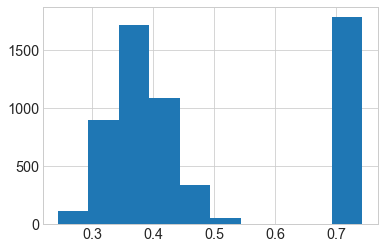

In [16]:
# ------------------------------------------------------------------------------------------------
# BASELINE: LINEAR MODEL
# ------------------------------------------------------------------------------------------------

@dataclass(eq=False)
class LinearModel(nn.Module):
    n_feats: int = N_FEATURES

    def __post_init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(self.n_feats, 1), nn.Sigmoid())

    def forward(self, X, mask):
        B, S, F = X.shape
        out = self.fc(X)  # B, S, 1
        assert tuple(out.shape) == (B, S, 1)
        return out[:,:,0]


# Build a linear model and show the prediction distribution
# ---------------------------------------------------------
lm = LinearModel().to(DEVICE)
input_, lbls, mask = next(iter(train_dl))
out = lm(input_, mask)
print(f"{out.shape=}")
preds = torch.squeeze(out[0]).detach().numpy()
# When era has fewer than 6k stocks, we pad those with -1 and predict
# a constant value for all those padded stocks. That's the spike below.
pd.Series(preds).hist();

In [17]:
# Train the linear model and see performance
# {metric -> [val_batch_1, val_batch_2...]}

# Predefine these if we want to run `train_model` multiple times
lm_train_metrics = MetricsSequence()
lm_eval_metrics = MetricsSequence()
lm = LinearModel().to(DEVICE)

In [69]:
train_model(
    model=lm,
    optimizer=optim.AdamW(lm.parameters(), lr=3e-4),
    train_dl=train_dl,
    val_dl=val_dl,
    num_epochs=200,
    criterion='corr',
    criterion_dirn='higher',
    model_path='./nn_models/linear.pkl',
    train_metrics=lm_train_metrics,
    eval_metrics=lm_eval_metrics,
)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

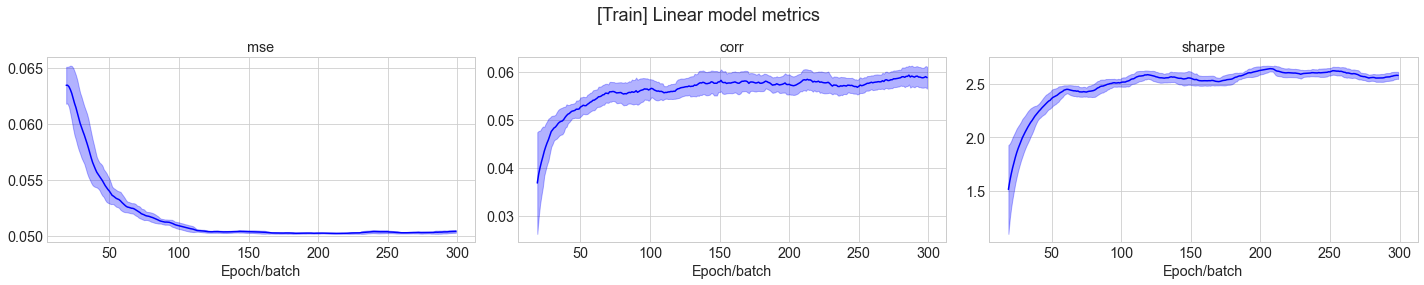

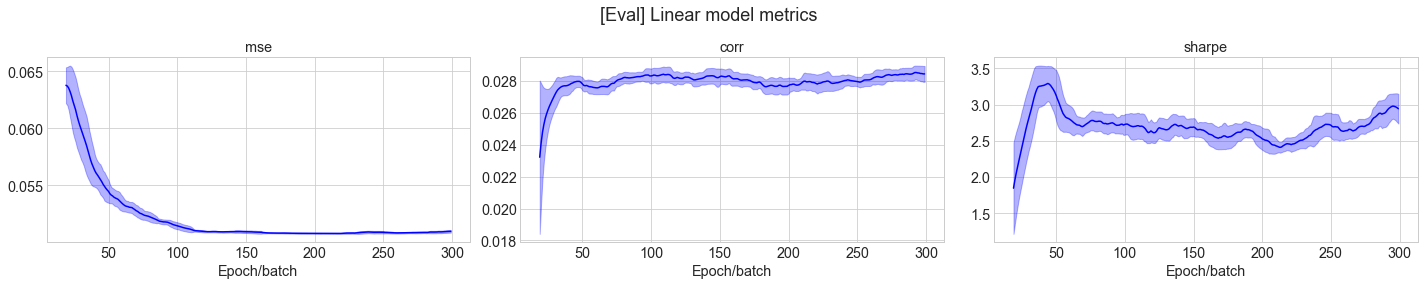

,mse,corr,sharpe
0,0.062118,0.009823,0.646173
1,0.062778,0.013454,0.832876
2,0.064001,0.016873,1.025966
3,0.064897,0.019243,1.187715
4,0.065964,0.020961,1.338623
...,...,...,...
295,0.050916,0.028177,2.951675
296,0.051147,0.027779,2.711529
297,0.051020,0.028123,2.684915
298,0.050968,0.028020,2.667811


In [70]:
MetricsSequence.plot(lm_train_metrics, title='[Train] Linear model metrics')
MetricsSequence.plot(lm_eval_metrics, title='[Eval] Linear model metrics')
display(MetricsSequence.tabular(lm_eval_metrics))

### 3.1 Predict test-set for validation diagnostics at https://numer.ai/scores

In [52]:
# ------------------------------------------------------------------------------------------------
# Predict test-set for validation diagnostics at https://numer.ai/scores
# ------------------------------------------------------------------------------------------------

def predict_dl(model, dl):
    # (E*S) x 1 where (E*S) includes all era x stock pair in input data 
    return torch.concat(
        [
            predict_batch(model=model, batch=batch)
            for batch in tqdm(dl, leave=False, desc="Batches")
        ],
        dim=0,
    )

@torch.no_grad()
def predict_batch(model, batch):
    was_in_train = model.training
    model.eval()
    inputs, target, mask = batch
    preds = model(inputs, mask)
    if was_in_train:
        # leave the model in the same state it came in
        model.train()
    return preds[mask]  # (B*S'); S' only includes unpadded stocks


def build_val_submission(model, test_df, test_dl) -> pd.DataFrame:
    preds = predict_dl(model=model, dl=test_dl).detach().numpy()
    df = pd.Series(
        predict_dl(model=model, dl=test_dl).detach().numpy(),
        index=test_df.index,
    ).reset_index()
    df.columns = ["id", "prediction"]
    # Print stats
    print(f"{test_df.shape=}, {preds.shape=}")
    corr = numerai_corr_stats(
        eras=test_df.era,
        pred=df.set_index('id'),
        target=test_df.target_cyrus_v4_20,
    )
    print(f"Corr: {corr}")
    return df

In [72]:
# These are the validation metrics. As we can see a simple linear model is a lot weaker
# than an lgbm model.
lm_pred_df = build_val_submission(model=lm, test_df=test_df, test_dl=test_dl)
# lm_pred_df.to_csv("./nn_models/linear_preds.csv", index=False)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

test_df.shape=(2546387, 645), preds.shape=(2546387,)
Corr: {'corr': 0.010520520578405258, 'sharpe': 0.5533180994417677}


## 4. Alternative Models

In [ ]:
gc.collect()

In [33]:
# ------------------------------------------------------------------------------------------------
# LINEAR MODEL WITH DROPOUT
#
# Features can be useful in early eras and become uncorrelated in later eras. It makes sense
# that we might want to be robust to any one feature. To encourage this let's train with fairly
# high dropout so that we implicitly learn an ensemble model.
#
# No intersting result, performance roughly the same
# ------------------------------------------------------------------------------------------------
@dataclass(eq=False)
class FC(nn.Module):
    n_feats: int = N_FEATURES
    n_hidden: int = 32

    def __post_init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(self.n_feats, self.n_hidden),
            nn.GELU(),
            nn.Linear(self.n_hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, X, mask):
        B, S, F = X.shape
        out = self.fc(X)  # B, S, 1
        assert tuple(out.shape) == (B, S, 1)
        return out[:,:,0]

In [36]:
# Train the linear model with dropout and see performance
# Predefine these if we want to run `train_model` multiple times
fc_train_metrics = MetricsSequence()
fc_eval_metrics = MetricsSequence()
fc = FC().to(DEVICE)

In [49]:
train_model(
    model=fc,
    optimizer=optim.AdamW(fc.parameters(), lr=3e-4),
    train_dl=train_dl,
    val_dl=val_dl,
    num_epochs=1,
    criterion='corr',
    criterion_dirn='higher',
    model_path='./nn_models/linear_w_dropout.pkl',
    train_metrics=fc_train_metrics,
    eval_metrics=fc_eval_metrics,
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train batch:   0%|          | 0/11 [00:00<?, ?it/s]

Eval batch:   0%|          | 0/5 [00:00<?, ?it/s]

In [47]:
fc_train_metrics.m2seq

defaultdict(list,
            {'mse': [0.050002275542779404,
              0.04986672442067753,
              0.0498985770073804,
              0.05009111186320132,
              0.050170011818408966,
              0.050063423812389374,
              0.05021736195141619,
              0.05013387447053736,
              0.04974294182929126,
              0.04966409402814778,
              0.049608959393067795,
              0.04955394430594011,
              0.04957846010273153,
              0.04957962307063016,
              0.049603851681405846,
              0.049591693011197174,
              0.04958317699757489,
              0.049644627354361794,
              0.049606954170898956,
              0.04963081668723713,
              0.049647740003737534,
              0.0496826402165673,
              0.0496566773138263,
              0.04966471344232559,
              0.049672452224926514,
              0.04963236877864057,
              0.049667259847575966,
              0.049624

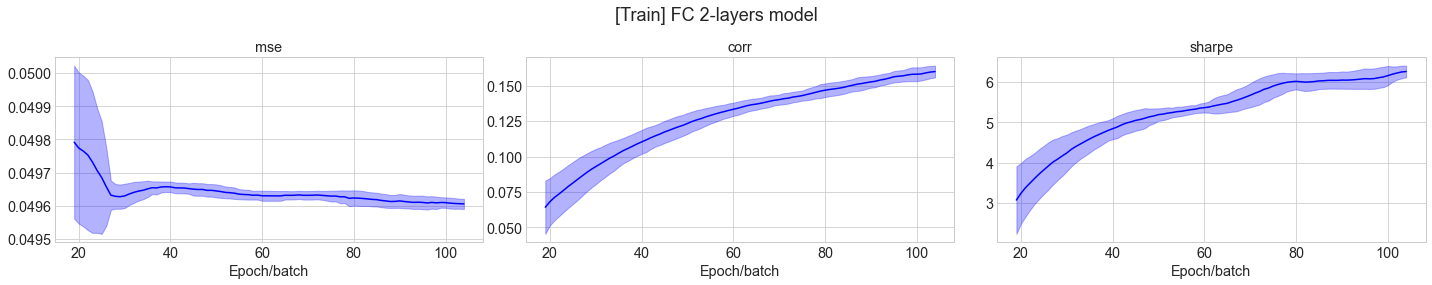

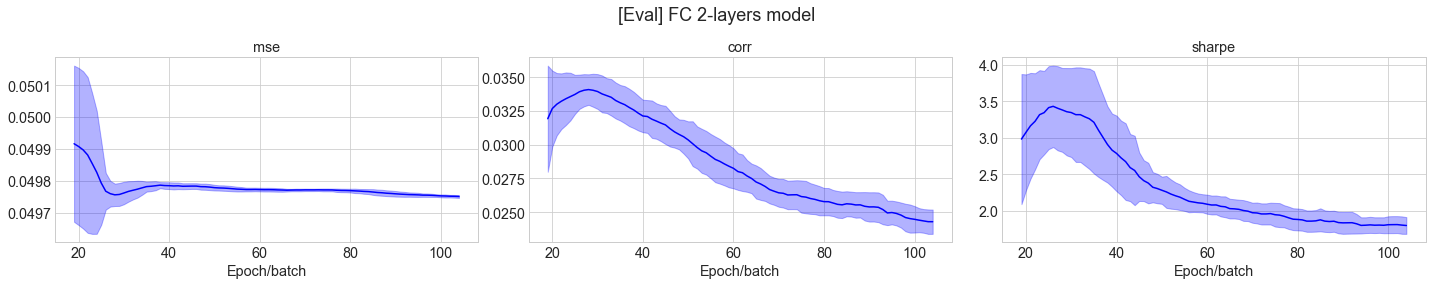

,mse,corr,sharpe
0,0.049958,0.019760,1.209638
1,0.050003,0.025610,1.637266
2,0.050085,0.028493,1.839562
3,0.050340,0.030224,2.019670
4,0.050324,0.029733,2.228211
...,...,...,...
100,0.049743,0.025162,1.981607
101,0.049744,0.025085,1.897843
102,0.049750,0.024081,1.718262
103,0.049746,0.023308,1.683114


In [50]:
MetricsSequence.plot(fc_train_metrics, title='[Train] FC 2-layers model')
MetricsSequence.plot(fc_eval_metrics, title='[Eval] FC 2-layers model')
MetricsSequence.tabular(fc_eval_metrics)

In [51]:
lmd_pred_df = build_val_submission(model=fc, test_df=test_df, test_dl=test_dl)

NameError: name 'build_val_submission' is not defined

In [ ]:
# Define the model, loss function, and optimizer
gc.collect()
transformer = Transformer(
    input_dim=FEATURE_DIM,
    d_model=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
)

# load model from checkpoint
if "transformer.pth" in os.listdir():
    transformer.load_state_dict(torch.load("transformer.pth"))

transformer.to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters(), lr=1e-4)

# Number of training iterations
# Train for longer with low LR

num_epochs = 10

transformer = train_model(transformer, optimizer, num_epochs, era2data_train, era2data_validation)

# Test

In [15]:
def test_corr_masked():
    """Compare the above implementation with an iterative numpy implementation"""
    # Given padded inputs and targets where each row is an era and each
    # column is a stock's model's prediction or label or padding mask
    B, S = 4, 5000  # batchsize (eras) and num_stock
    pred = np.random.random((B, S))
    target = np.random.random((B, S))
    mask = np.random.random((B, S)) > 0.3
    # When we compute erawise pearson corr with the label
    res = corr_masked(
        pred=torch.from_numpy(pred),
        target=torch.from_numpy(target),
        mask=torch.from_numpy(mask),
    )
    # Then we should compute pearson corr after masking
    res_corr = res["erawise_corr"].detach().numpy()
    for  _rcorr, _o, _l, _m in zip(res_corr, pred, target, mask):
        np.testing.assert_almost_equal(_rcorr[0], np.corrcoef(_o[_m], _l[_m])[0,1])

test_corr_masked()